# Attention Mechanisms: From Static to Contextual Embeddings

In this notebook, we'll explore how Attention mechanisms solve the inherent limitations of static embeddings, using GPT-2 to illustrate practical examples and visualize real attention weights.

### Learning Objectives

By the end of this notebook, you'll:

- Understand the limitations of static embeddings.
- Recognize why context-aware embeddings are essential.
- Clearly understand how attention mechanisms work.
- Visualize real attention weights from GPT-2.

We'll use Hugging Face's transformers and PyTorch.

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()


## Static Embeddings: What's the Problem?

Static embeddings assign one fixed vector per word, ignoring context. Let's illustrate this clearly.

We'll extract GPT-2's embedding layer to see what static embeddings look like.

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

# Extracting embedding layer
embeddings = model.wte.weight.data
print("Embedding shape:", embeddings.shape)


Embedding shape: torch.Size([50257, 768])


### Problem Example

Consider the word "bank" with two different meanings:

* **Financial:** "I deposited money at the bank."
* **River side:** "The river bank was muddy."

Let's verify the embedding for "bank" is identical, ignoring context:

In [30]:
text1 = "I deposited money in the bank"
text2 = "I withdrew money from the bank"

tokens1 = tokenizer.tokenize(text1)
tokens2 = tokenizer.tokenize(text2)
    
print("Tokens for text1:", tokens1)
print("Tokens for text2:", tokens2)

token_ids1 = tokenizer.convert_tokens_to_ids(tokens1)
token_ids2 = tokenizer.convert_tokens_to_ids(tokens2)

print("\nToken IDs for text1:", token_ids1)
print("Token IDs for text2:", token_ids2)

# Convert token ID of 'bank' to embeddings
bank1_embedding = embeddings[token_ids1[-1]]
bank2_embedding = embeddings[token_ids2[-1]]

torch.allclose(bank1_embedding, bank2_embedding)


Tokens for text1: ['I', 'Ġdeposited', 'Ġmoney', 'Ġin', 'Ġthe', 'Ġbank']
Tokens for text2: ['I', 'Ġwithdrew', 'Ġmoney', 'Ġfrom', 'Ġthe', 'Ġbank']

Token IDs for text1: [40, 27163, 1637, 287, 262, 3331]
Token IDs for text2: [40, 25518, 1637, 422, 262, 3331]


True

## Why Context Matters: Contextual Embeddings

To address this issue, modern NLP models use **contextual embeddings**, generated dynamically based on sentence context.

Let's illustrate using GPT-2 hidden states (contextual embeddings):

In [34]:
def get_contextual_embedding(sentence, target_word):
    inputs = tokenizer(sentence, return_tensors='pt')
    outputs = model(**inputs)
    hidden_states = outputs.last_hidden_state[0]

    token_ids = tokenizer.encode(sentence)
    token_strs = tokenizer.convert_ids_to_tokens(token_ids)
    
    # Find target word positions
    positions = [i for i, tok in enumerate(token_strs) if target_word in tok]
    print("Positions of target word:", positions)

    embeddings = hidden_states[positions]
    return embeddings.mean(dim=0)  # average if split into subwords


Let's check embeddings for "bank" in two different sentences:

In [36]:
sentence1 = "I deposited money at the bank."
sentence2 = "The river bank was slippery."

emb1 = get_contextual_embedding(sentence1, "bank")
emb2 = get_contextual_embedding(sentence2, "bank")

print("Contextual embedding (financial bank):", emb1[:5])
print("Contextual embedding (river bank):", emb2[:5])

# Compute similarity
torch.allclose(emb1, emb2)  # Check if they are the same


Positions of target word: [5]
Positions of target word: [2]
Contextual embedding (financial bank): tensor([ 0.1930, -0.2760, -1.4686, -0.1336,  0.4906], grad_fn=<SliceBackward0>)
Contextual embedding (river bank): tensor([-0.7199,  0.3620, -1.1814,  0.5363,  0.2423], grad_fn=<SliceBackward0>)


False

## Introducing Attention: How Contextual Embeddings are Created

Attention mechanisms allow models to dynamically weigh the importance of each word based on context.

**Key components of Attention:**

* **Query (Q):** Current word representation seeking context.
* **Key (K):** Words providing context.
* **Value (V):** Embeddings combined according to computed attention weights.

The simplified Scaled Dot-Product Attention formula is:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

In [37]:
import torch.nn.functional as F

def scaled_dot_product_attention(Q, K, V):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    attn_weights = F.softmax(scores, dim=-1)
    return torch.matmul(attn_weights, V), attn_weights


### Visualizing Real Attention from GPT-2

GPT-2 calculates attention internally. We can extract these weights to visualize the relation ships between different parts of a sentence

In [59]:
# Pass output_attentions=True to extract attentions
sentence = "The cat sat on the mat because it was warm."
inputs = tokenizer(sentence, return_tensors='pt')
outputs = model(**inputs, output_attentions=True)

# GPT-2 attention dimensions:
# (num_layers, batch_size, num_heads, seq_len, seq_len)
attention = outputs.attentions[-1][0, 0]  # last layer, first batch, first head

tokens = tokenizer.tokenize(sentence)
print("Attention weights shape:", attention.shape)


Attention weights shape: torch.Size([11, 11])


Attention weights show which words are most important when creating context-aware embeddings.

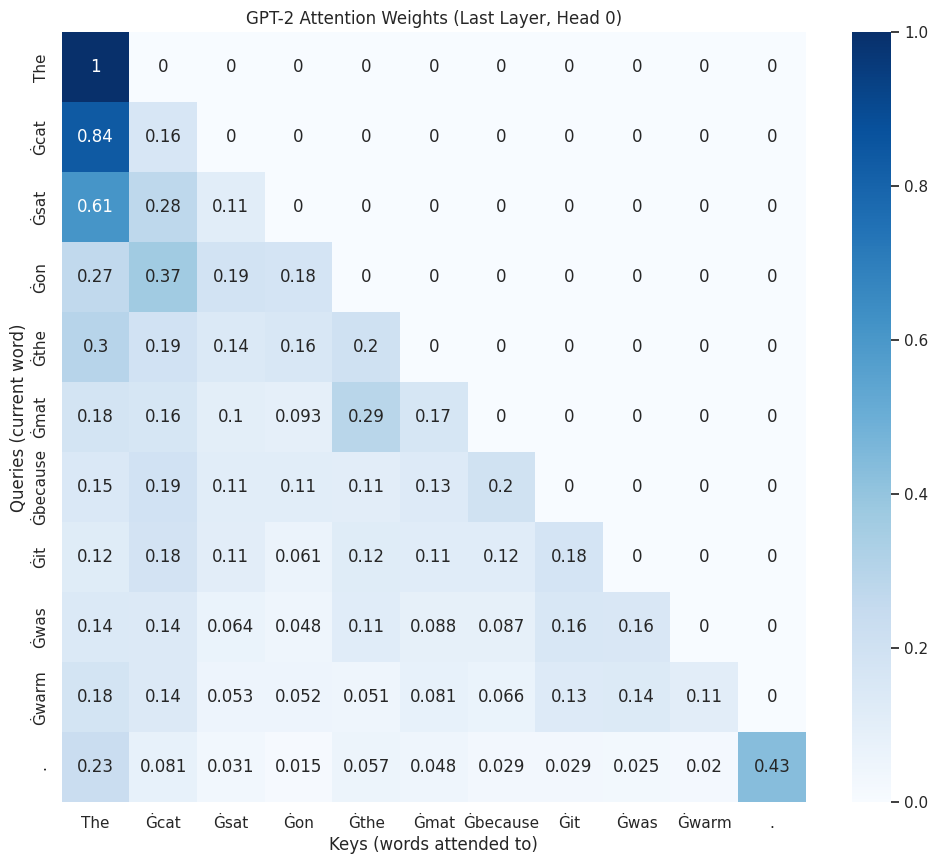

In [60]:
plt.figure(figsize=(12, 10))
sns.heatmap(attention.detach().numpy(), xticklabels=tokens, yticklabels=tokens, cmap='Blues', annot=True)
plt.xlabel("Keys (words attended to)")
plt.ylabel("Queries (current word)")
plt.title("GPT-2 Attention Weights (Last Layer, Head 0)")
plt.show()


## Multi-Head Attention

GPT-2 and Transformers use **multiple attention heads** to capture different aspects of context simultaneously.

Let's quickly see multi-head attention in PyTorch:

In [66]:
from numpy import average


multihead_attn = torch.nn.MultiheadAttention(embed_dim=768, num_heads=8)

# Example embeddings (seq_len, batch, embed_dim)
query = key = value = torch.rand(6, 1, 768)
output, attn_weights = multihead_attn(query, key, value, need_weights=True, average_attn_weights=False)

print("Output shape:", output.shape)
print("Attention weights shape:", attn_weights.shape)


Output shape: torch.Size([6, 1, 768])
Attention weights shape: torch.Size([1, 8, 6, 6])


In [62]:
from transformers import GPT2Tokenizer, GPT2Model
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Load GPT-2 and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

# Input sentence
sentence = "The cat sat on the mat because it was warm."

# Tokenize and get outputs with attentions
inputs = tokenizer(sentence, return_tensors='pt')
outputs = model(**inputs, output_attentions=True)

# Get attentions: (num_layers, batch, num_heads, seq_len, seq_len)
attentions = outputs.attentions  # list of 12 layers

# Let's look at the last layer (layer -1)
last_layer_attention = attentions[-1][0]  # shape: (num_heads, seq_len, seq_len)

print(f"Attention shape: {last_layer_attention.shape}")  # should be (12, seq_len, seq_len)


Attention shape: torch.Size([12, 11, 11])


#### GPT-2 has:

* 12 layers (also called transformer blocks),  
* Each layer has 12 attention heads (for GPT-2 small),  
* The attention output is shaped as:  

        (num_layers, batch_size, num_heads, seq_len, seq_len) 

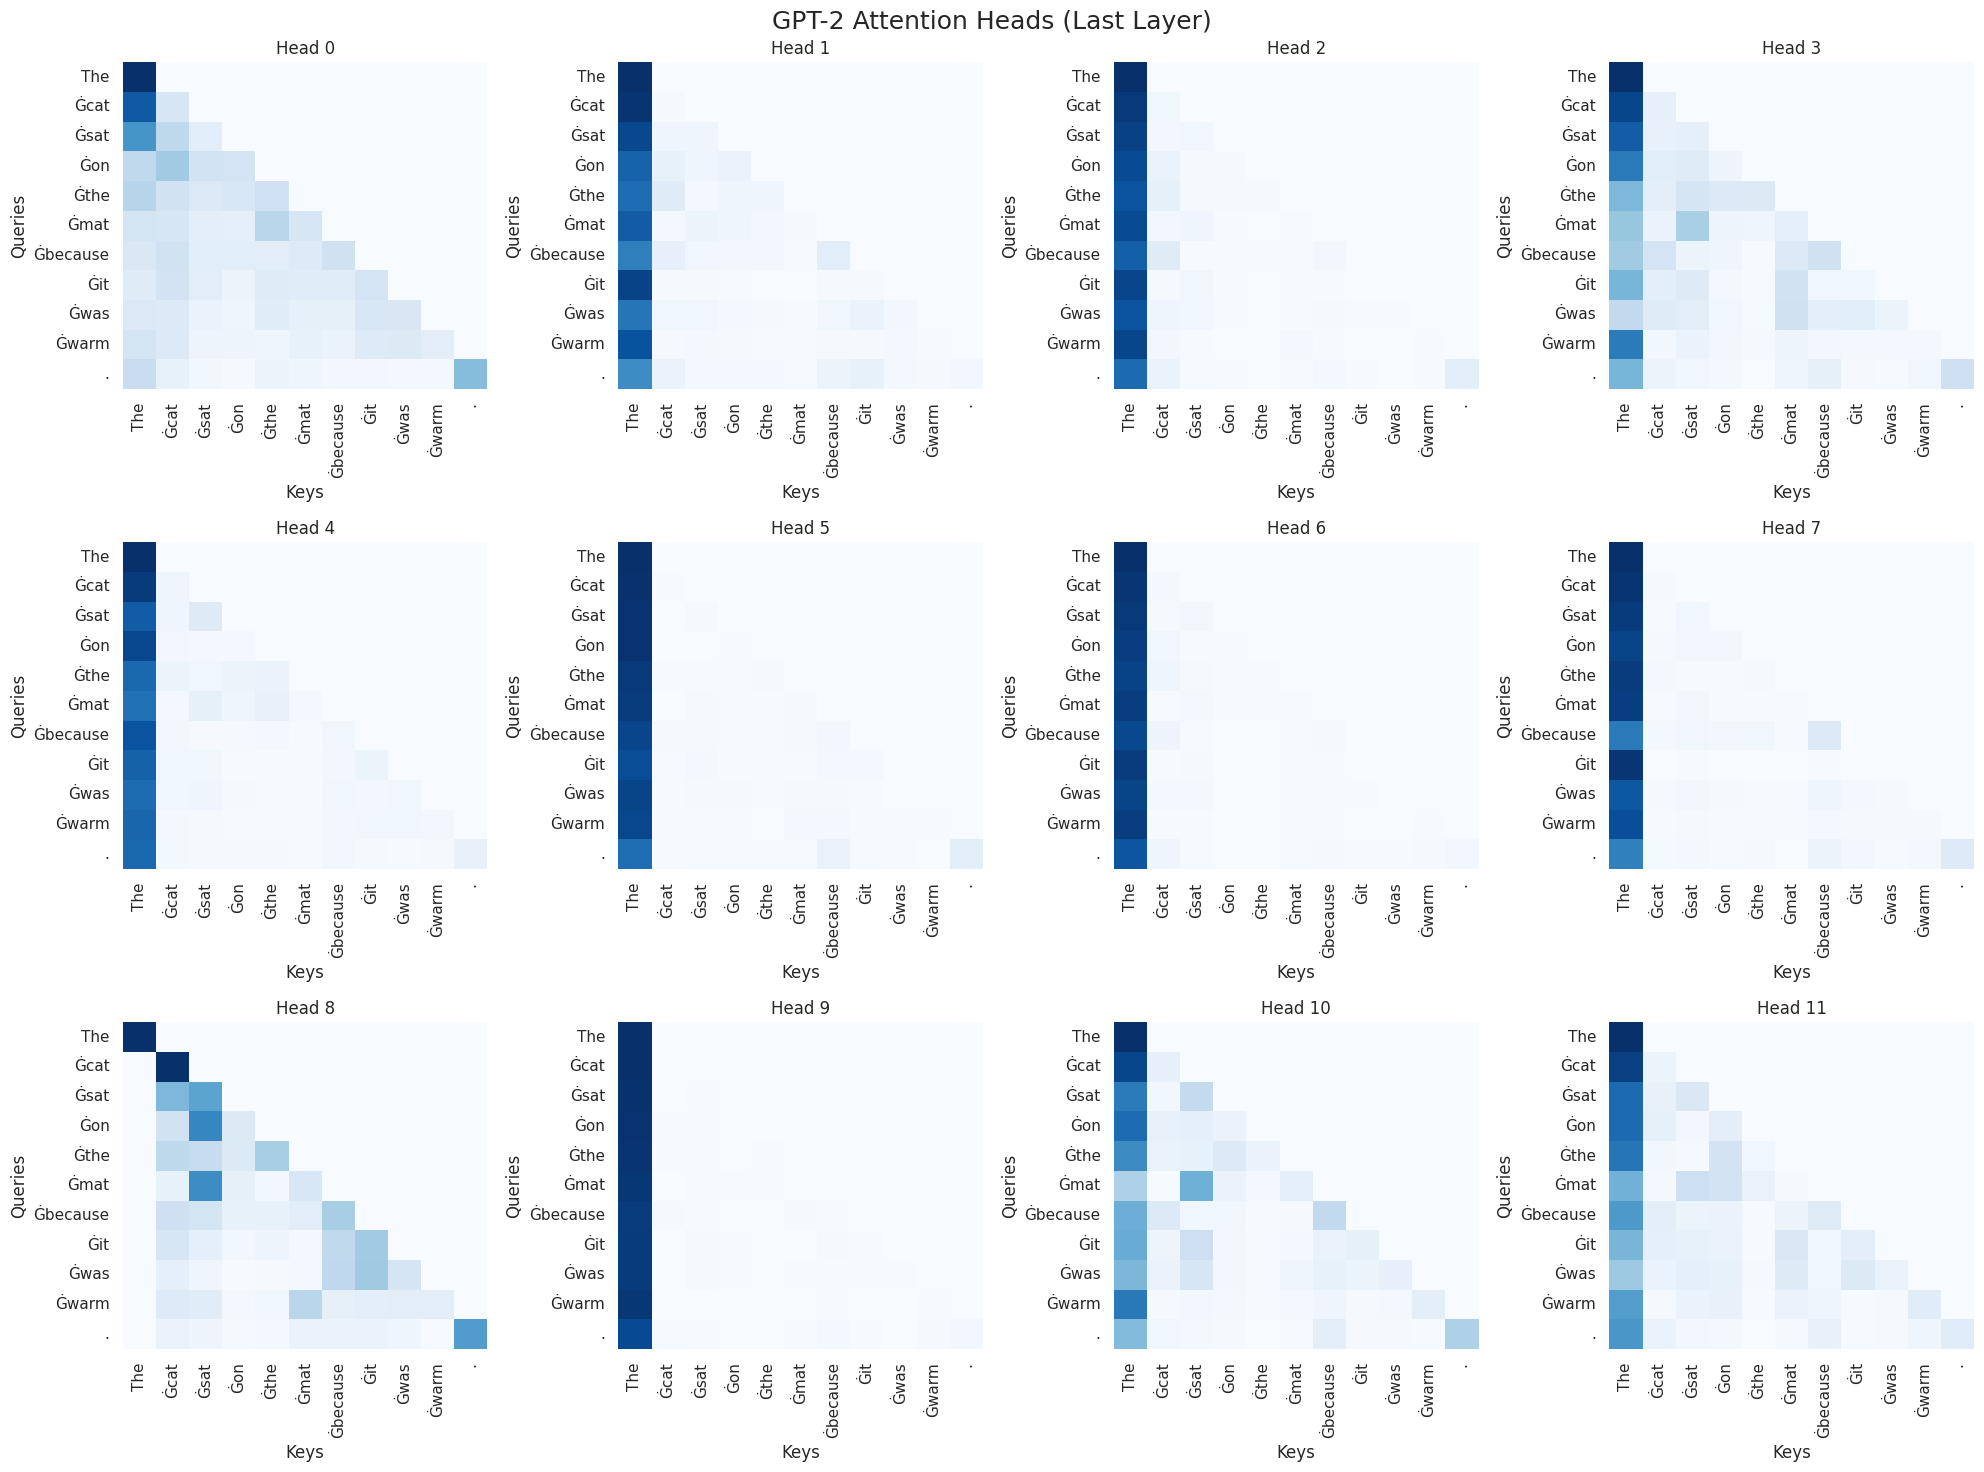

In [63]:
tokens = tokenizer.tokenize(sentence)
num_heads = last_layer_attention.shape[0]

fig, axes = plt.subplots(3, 4, figsize=(20, 15))  # 12 heads = 3 rows × 4 cols

for i, ax in enumerate(axes.flat):
    if i < num_heads:
        sns.heatmap(last_layer_attention[i].detach().numpy(),
                    xticklabels=tokens, yticklabels=tokens,
                    cmap='Blues', ax=ax, cbar=False)
        ax.set_title(f"Head {i}")
        ax.set_xlabel("Keys")
        ax.set_ylabel("Queries")
    else:
        ax.axis('off')

plt.suptitle("GPT-2 Attention Heads (Last Layer)", fontsize=18)
plt.tight_layout()
plt.show()


## Summary & Takeaways

* Static embeddings are limited as they ignore context.
* Attention mechanisms dynamically create contextual embeddings.
* Contextual embeddings are crucial for understanding language accurately.